In [41]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/ahmedmajid/Desktop/Digital-Twin-for Smart-Energy-Meters/digital-twin-mvp/data/processed_telemetry.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [42]:
from sklearn.ensemble import IsolationForest
import joblib

model = joblib.load("/Users/ahmedmajid/Desktop/Digital-Twin-for Smart-Energy-Meters/isolation_forest_model.pkl")

# predict ML anomalies again
features = [
    "temperature", "vibration", "pressure",
    "temp_roll_mean", "temp_roll_std",
    "vib_roll_mean", "vib_roll_std",
    "pres_roll_mean", "pres_roll_std"
]

df['iforest_pred'] = model.predict(df[features])
df['ml_anomaly'] = df['iforest_pred'].apply(lambda x: 1 if x == -1 else 0)

In [43]:
# Temperature risk (0 to 1)
df['temp_risk'] = np.where(df['temperature'] < 60, 0,
                     np.where(df['temperature'] < 70, 0.4, 1.0))

# Vibration risk
df['vib_risk'] = np.where(df['vibration'] < 1.5, 0,
                     np.where(df['vibration'] < 2.0, 0.5, 1.0))

# Pressure risk
df['pres_risk'] = np.where((df['pressure'] > 95) & (df['pressure'] < 115), 0, 1.0)

In [44]:
df['stat_risk'] = (
    df['temp_roll_std'] / df['temp_roll_mean'] +
    df['vib_roll_std'] / df['vib_roll_mean'] +
    df['pres_roll_std'] / df['pres_roll_mean']
) / 3

In [45]:
df['stat_risk'] = df['stat_risk'].clip(0, 1)

In [46]:
df['ml_risk'] = df['ml_anomaly'] * 1.0  # 1 = anomaly, 0 = normal

In [47]:
W1, W2, W3 = 0.4, 0.3, 0.3

df['risk_total'] = (
    W1 * (df['temp_risk'] + df['vib_risk'] + df['pres_risk'])/3 +
    W2 * df['stat_risk'] +
    W3 * df['ml_risk']
)

df['MHI'] = (100 * (1 - df['risk_total'])).clip(0, 100)

In [48]:
df[['timestamp', 'temperature', 'vibration', 'pressure', 'MHI']].head()

,timestamp,temperature,vibration,pressure,MHI
0,2025-12-04 14:45:02.243591,40.20,0.80,101.20,91.700990
1,2025-12-04 14:45:55.603153,61.51,1.27,94.35,73.034324
2,2025-12-04 14:45:57.628967,74.76,0.32,90.91,65.034324
3,2025-12-04 14:45:59.638021,57.14,0.32,98.44,91.700990
4,2025-12-04 14:46:01.648827,53.13,0.77,95.16,91.700990


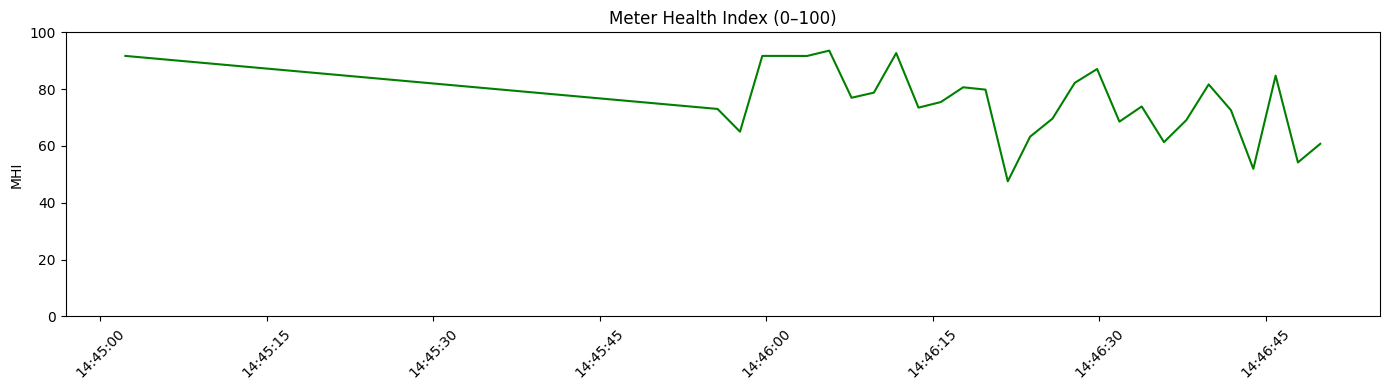

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(df['timestamp'], df['MHI'], color='green')
plt.ylim(0, 100)
plt.title("Meter Health Index (0–100)")
plt.ylabel("MHI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()